--- Análisis Automático ---
Saturación media del fondo: 133.87
Decisión: Fondo de color detectado. Usando Segmentación HSV.
--------------------------
[INFO] Calibración completa. Escala: 24.73 px/mm


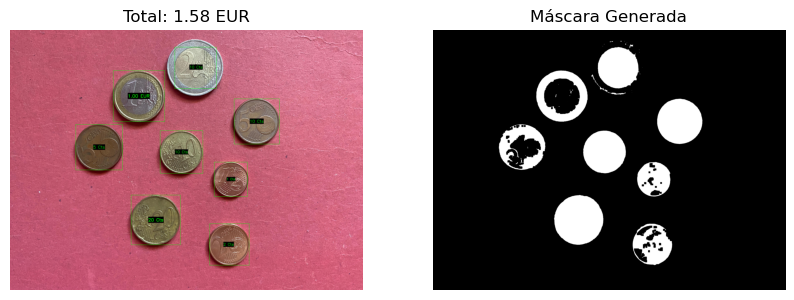

In [ ]:
# --- LIBRERÍAS ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN INICIAL ---
nombre_archivo = 'Monedas.jpeg'

# --- DATOS DE REFERENCIA ---
DATOS_MONEDAS = {
    "1 Céntimo": (16.25, 0.01), "2 Céntimos": (18.75, 0.02),
    "5 Céntimos": (21.25, 0.05), "10 Céntimos": (19.75, 0.10),
    "20 Céntimos": (22.25, 0.20), "50 Céntimos": (24.25, 0.50),
    "1 Euro": (23.25, 1.00), "2 Euros": (25.75, 2.00),
}
pixels_per_mm = None

# --- FUNCIONES AUXILIARES ---
def redimensionar_para_mostrar(imagen, ancho_max=1024):
    h, w = imagen.shape[:2]
    if w > ancho_max:
        ratio = ancho_max / float(w)
        return cv2.resize(imagen, (ancho_max, int(h * ratio)), interpolation=cv2.INTER_AREA)
    return imagen

def calibrar_escala(event, x, y, flags, param):
    global pixels_per_mm
    if event == cv2.EVENT_LBUTTONDOWN:
        contornos, ratio_redimension = param
        x_orig, y_orig = int(x / ratio_redimension), int(y / ratio_redimension)
        contorno_ref = min(contornos, key=lambda c: np.min(np.sum((c - [x_orig, y_orig])**2, axis=2)))
        (_, radio_px) = cv2.minEnclosingCircle(contorno_ref)
        diametro_px = radio_px * 2
        diametro_ref_mm = DATOS_MONEDAS["1 Euro"][0]
        pixels_per_mm = diametro_px / diametro_ref_mm
        print(f"[INFO] Calibración completa. Escala: {pixels_per_mm:.2f} px/mm")

# --- INICIO DEL PROCESAMIENTO PRINCIPAL ---
img_original = cv2.imread(nombre_archivo)

if img_original is None:
    print(f"Error: No se pudo cargar la imagen '{nombre_archivo}'.")
else:
    # --- ANÁLISIS AUTOMÁTICO DEL FONDO ---
    h, w = img_original.shape[:2]
    corner_size = int(min(h, w) * 0.1)
    corners = [
        img_original[0:corner_size, 0:corner_size],
        img_original[0:corner_size, w-corner_size:w],
        img_original[h-corner_size:h, 0:corner_size],
        img_original[h-corner_size:h, w-corner_size:w]
    ]
    border_pixels = np.vstack([c.reshape(-1, 3) for c in corners])
    hsv_border = cv2.cvtColor(np.uint8([border_pixels]), cv2.COLOR_BGR2HSV)
    avg_saturation = np.mean(hsv_border[0, :, 1])
    SATURATION_THRESHOLD = 25.0
    es_fondo_simple = avg_saturation < SATURATION_THRESHOLD

    print(f"--- Análisis Automático ---")
    print(f"Saturación media del fondo: {avg_saturation:.2f}")
    if es_fondo_simple:
        print("Decisión: Fondo simple detectado. Usando Umbral de Otsu.")
    else:
        print("Decisión: Fondo de color detectado. Usando Segmentación HSV.")
    print("--------------------------")

    # --- SELECCIÓN DEL MÉTODO DE SEGMENTACIÓN ---
    if es_fondo_simple:
        img_gris = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(img_gris, (15, 15), 0)
        _, mascara_limpia = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        img_blur = cv2.GaussianBlur(img_original, (11, 11), 0)
        img_hsv = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)
        limite_bajo = np.array([0, 0, 0])
        limite_alto = np.array([91, 116, 255])
        mascara_final = cv2.inRange(img_hsv, limite_bajo, limite_alto)
        kernel = np.ones((7, 7), np.uint8)
        mascara_limpia = cv2.morphologyEx(mascara_final, cv2.MORPH_CLOSE, kernel, iterations=3)

    contornos, _ = cv2.findContours(mascara_limpia.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- FASE DE CALIBRACIÓN INTERACTIVA ---
    img_calibracion_display = redimensionar_para_mostrar(img_original, ancho_max=1024)
    ratio = img_calibracion_display.shape[1] / float(img_original.shape[1])
    img_calibracion_con_contornos = img_calibracion_display.copy()
    contornos_display = [(c * ratio).astype(int) for c in contornos]
    cv2.drawContours(img_calibracion_con_contornos, contornos_display, -1, (0, 255, 0), 2)
    
    cv2.namedWindow("Calibracion: Clic en la moneda de 1 Euro")
    cv2.setMouseCallback("Calibracion: Clic en la moneda de 1 Euro", calibrar_escala, param=(contornos, ratio))

    while pixels_per_mm is None:
        cv2.imshow("Calibracion: Clic en la moneda de 1 Euro", img_calibracion_con_contornos)
        if cv2.waitKey(1) & 0xFF == 27:
            break
    cv2.destroyAllWindows()

    # --- FASE DE CONTEO Y VISUALIZACIÓN ---
    if pixels_per_mm is not None:
        img_resultado = img_original.copy()
        total_valor = 0.0
        for c in contornos:
            area = cv2.contourArea(c)
            if area < 500: continue
            
            perimetro = cv2.arcLength(c, True)
            if perimetro == 0: continue
            circularidad = 4 * np.pi * (area / (perimetro**2))
            
            if 0.70 < circularidad < 1.30:
                (cx, cy), radio_px = cv2.minEnclosingCircle(c)
                diametro_mm = (radio_px * 2) / pixels_per_mm
                
                moneda_identificada = None
                min_diff = float('inf')
                for nombre, (diametro_real, valor) in DATOS_MONEDAS.items():
                    diff = abs(diametro_mm - diametro_real)
                    if diff < min_diff and diff < 2.0:
                        min_diff = diff
                        moneda_identificada = (nombre, valor)
                
                if moneda_identificada:
                    nombre_moneda, valor_moneda = moneda_identificada
                    total_valor += valor_moneda
                    etiqueta = f"{valor_moneda:.2f} EUR" if valor_moneda >= 1 else f"{int(valor_moneda*100)} Cts"
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(img_resultado, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    
                    font_escala = (radio_px * 2) / 350.0
                    font_grosor = max(1, int(font_escala * 2))
                    
                    (ancho_texto, alto_texto), baseline = cv2.getTextSize(etiqueta, cv2.FONT_HERSHEY_SIMPLEX, font_escala, font_grosor)

                    # --- CAMBIO EN LA POSICIÓN DE LA ETIQUETA ---
                    # Se calcula la posición para que el texto quede centrado en la moneda.
                    # El origen del texto (esquina inferior izquierda) se calcula a partir del centro (cx, cy).
                    pos_texto_x = int(cx - ancho_texto / 2)
                    pos_texto_y = int(cy + alto_texto / 2)
                    
                    # Se dibuja el fondo negro en la nueva posición centrada.
                    fondo_y1 = pos_texto_y - alto_texto - baseline
                    fondo_y2 = pos_texto_y + baseline
                    cv2.rectangle(img_resultado, (pos_texto_x, fondo_y1), (pos_texto_x + ancho_texto, fondo_y2), (0, 0, 0), -1)
                    
                    # Se escribe el texto de la etiqueta sobre el fondo.
                    cv2.putText(img_resultado, etiqueta, (pos_texto_x, pos_texto_y), cv2.FONT_HERSHEY_SIMPLEX, font_escala, (0, 255, 0), font_grosor)

        texto_total = f"Total: {total_valor:.2f} EUR"
        
        # 1. Crear una figura más ancha para que quepan ambas imágenes
        plt.figure(figsize=(10, 7))

        # 2. Primer subplot (1 fila, 2 columnas, posición 1)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(redimensionar_para_mostrar(img_resultado), cv2.COLOR_BGR2RGB))
        plt.title(texto_total)
        plt.axis('off')

        # 3. Segundo subplot (1 fila, 2 columnas, posición 2)
        plt.subplot(1, 2, 2)
        plt.imshow(mascara_limpia, cmap='gray') # La máscara ya está en blanco y negro
        plt.title('Máscara Generada')
        plt.axis('off')

        # 4. Mostrar la figura completa con ambos subplots
        plt.show()


--- Resumen de Resultados ---
Total de partículas evaluadas: 96
Accuracy (Exactitud) General: 0.67

--- Métricas por Tipo de Partícula ---
              precision    recall  f1-score   support

         FRA       0.77      0.71      0.74        48
         PEL       0.90      0.53      0.67        34
         TAR       0.38      0.86      0.52        14

    accuracy                           0.67        96
   macro avg       0.68      0.70      0.64        96
weighted avg       0.76      0.67      0.68        96

------------------------------------


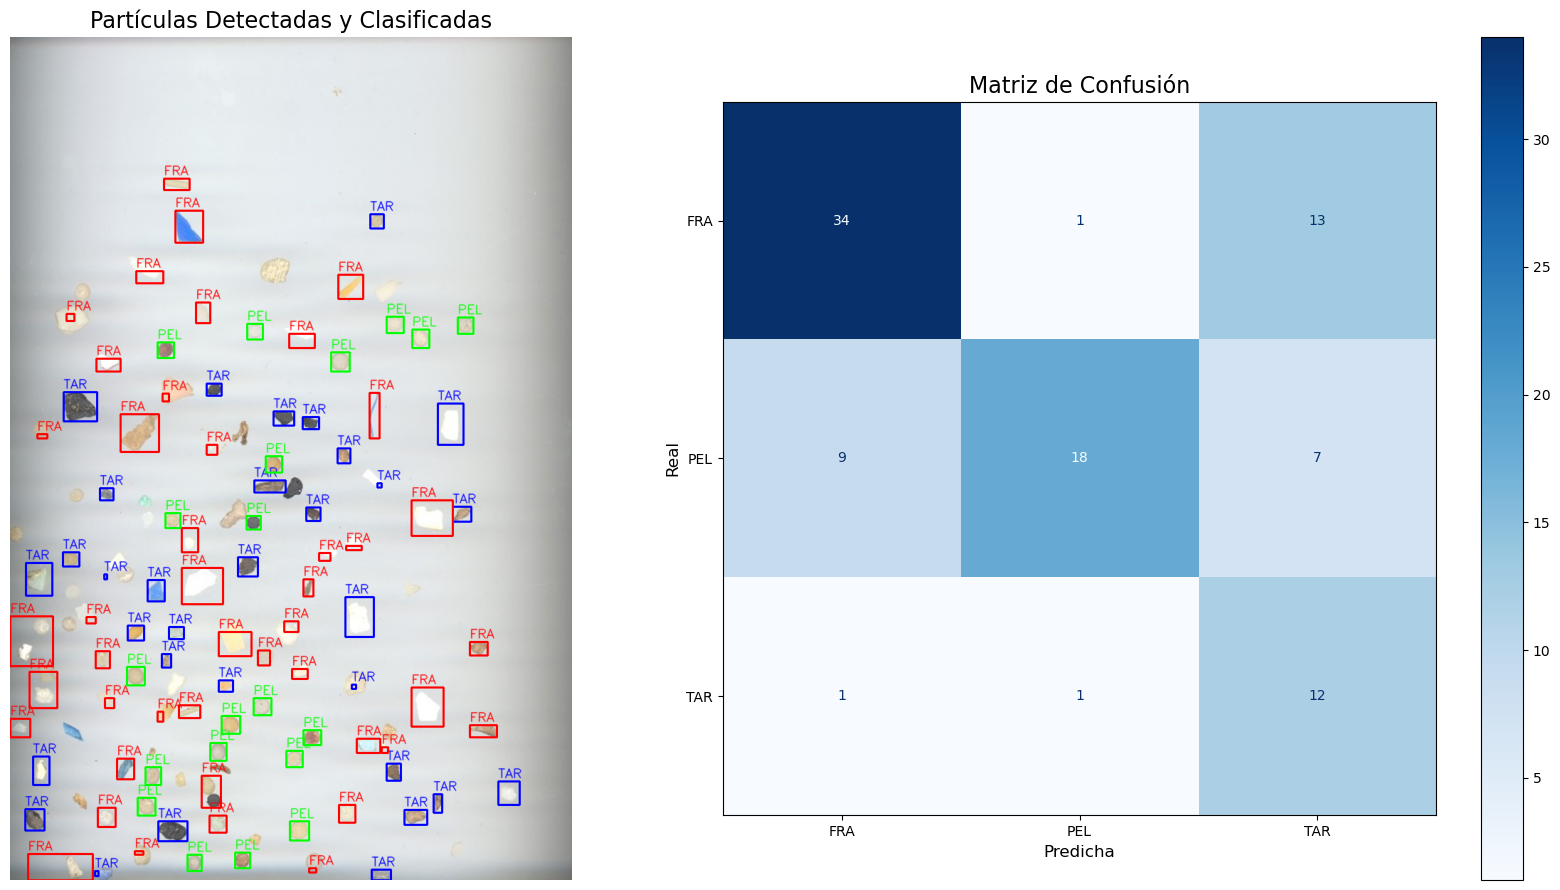

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# La función get_features se mantiene sin cambios
def get_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    blurred = cv2.GaussianBlur(img_clahe, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 15, 2)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features_list = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 15:
            perimeter = cv2.arcLength(cnt, True)
            if perimeter == 0: continue
            
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            
            x, y, w, h = cv2.boundingRect(cnt)
            
            M = cv2.moments(cnt)
            cX = int(M["m10"] / M["m00"]) if M["m00"] != 0 else x + w//2
            cY = int(M["m01"] / M["m00"]) if M["m00"] != 0 else y + h//2

            features_list.append({
                "circularity": circularity,
                "centroid": (cX, cY),
                "bbox": (x, y, w, h)
            })
    return features_list

# La función analizar_caracteristicas_entrenamiento se mantiene sin cambios
def analizar_caracteristicas_entrenamiento(training_data):
    stats = {}
    # print("Analizando imágenes de entrenamiento para determinar umbrales...") # Silenciado
    for label, image_path in training_data.items():
        particles = get_features(image_path)
        circularities = [p['circularity'] for p in particles]
        if circularities:
            stats[label] = {'mean_circularity': np.mean(circularities)}
            # print(f"  - Clase: {label}, Circularidad Media: {stats[label]['mean_circularity']:.3f}") # Silenciado
    return stats

# La función crear_clasificador_dinamico se mantiene con la última mejora
def crear_clasificador_dinamico(stats):
    umbral_fra_tar = (stats['FRA']['mean_circularity'] + stats['TAR']['mean_circularity']) / 2
    
    # print(f"\nUmbrales calculados:") # Silenciado
    # print(f"  - Umbral fijo para PEL: > 0.85") # Silenciado
    # print(f"  - Umbral dinámico FRA/TAR: {umbral_fra_tar:.3f}\n") # Silenciado
    
    def clasificar(particle_features):
        circularity = particle_features['circularity']
        if circularity > 0.85:
            return "PEL"
        elif circularity < umbral_fra_tar:
            return "FRA"
        else:
            return "TAR"
            
    return clasificar

# --- FASE 3: EJECUCIÓN Y EVALUACIÓN ---

# 1. Definir datos de entrenamiento
training_images = {"FRA": "FRA.png", "PEL": "PEL.png", "TAR": "TAR.png"}

# 2. Aprender las estadísticas
estadisticas_entrenamiento = analizar_caracteristicas_entrenamiento(training_images)

# 3. Crear el clasificador con umbrales dinámicos
clasificador_final = crear_clasificador_dinamico(estadisticas_entrenamiento)

# 4. Evaluar en la imagen de test
test_particles = get_features('MPs_test.jpg')
annotations = pd.read_csv("MPs_test_bbs.csv")

y_true = []
y_pred = []
detected_and_classified_bboxes = [] # Almacenar bboxes y etiquetas predichas para dibujar

class_names = sorted(training_images.keys(), key=lambda k: estadisticas_entrenamiento[k]['mean_circularity'])

# Colores para dibujar las clasificaciones
colors = {
    "FRA": (0, 0, 255),   # Rojo para Fragmentos
    "PEL": (0, 255, 0),   # Verde para Pellets
    "TAR": (255, 0, 0)    # Azul para Alquitrán
}

# Cargar la imagen original a color para dibujar sobre ella
image_with_detections = cv2.imread('MPs_test.jpg')
if image_with_detections is None:
    print("Error: No se pudo cargar MPs_test.jpg para dibujar las detecciones.")
    exit()

for index, row in annotations.iterrows():
    true_label = row['label']
    x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
    
    best_match = None
    particles_copy = test_particles[:] 
    for particle in particles_copy:
        cx, cy = particle['centroid']
        if x_min < cx < x_max and y_min < cy < y_max:
            best_match = particle
            test_particles.remove(particle) 
            break
    
    if best_match:
        predicted_label = clasificador_final(best_match)
        y_true.append(true_label)
        y_pred.append(predicted_label)
        
        detected_and_classified_bboxes.append({
            "bbox": best_match["bbox"],
            "predicted_label": predicted_label
        })

# 5. Dibujar detecciones en la imagen
for det in detected_and_classified_bboxes:
    x, y, w, h = det["bbox"]
    label = det["predicted_label"]
    color = colors.get(label, (255, 255, 255)) 

    cv2.rectangle(image_with_detections, (x, y), (x+w, y+h), color, 2)
    cv2.putText(image_with_detections, label, (x, y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 1, cv2.LINE_AA)

# Convertir de BGR a RGB para mostrar con matplotlib
image_with_detections_rgb = cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB)

# 6. Mostrar Matriz de Confusión y plots
cm = confusion_matrix(y_true, y_pred, labels=class_names)
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].imshow(image_with_detections_rgb)
axes[0].set_title('Partículas Detectadas y Clasificadas', fontsize=16)
axes[0].axis('off')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Matriz de Confusión', fontsize=16)
axes[1].set_xlabel('Predicha', fontsize=12)
axes[1].set_ylabel('Real', fontsize=12)

plt.tight_layout()

# --- 7. ÚNICA SALIDA DE TEXTO: RESUMEN DE MÉTRICAS ---
print("\n--- Resumen de Resultados ---")
print(f"Total de partículas evaluadas: {len(y_true)}")

if len(y_true) > 0:
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, labels=class_names)
    
    print(f"Accuracy (Exactitud) General: {accuracy:.2f}\n")
    print("--- Métricas por Tipo de Partícula ---")
    print(report)
    print("------------------------------------")

plt.show()